In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 100)

In [ ]:
df = pd.read_csv(
    "/content/gdrive/My Drive/Colab Notebooks/TaxiFare/train.csv", 
    index_col="tripid"
)
print(df.dtypes)
df.head()

In [ ]:
label_df = pd.DataFrame(df['label'])
feature_df = df.drop(columns='label')
feature_df.head()

In [ ]:
label_df['label_copy'] = label_df['label']
labels ={"label": {"correct": 1, "incorrect": 0}}
label_df.replace(labels, inplace=True)
label_df.head()

In [ ]:
label_df['label'].value_counts()

1    15495
0     1681
Name: label, dtype: int64

In [ ]:
misid = np.where(feature_df[['fare']].isnull())[0]
newl = label_df.drop(label_df.index[misid])
newl['label'].value_counts()

# All the fare missing 137 samples are incorrect samples

1    15495
0     1544
Name: label, dtype: int64

In [ ]:
label_df.drop(columns='label_copy', inplace=True)
label_df.head()

In [ ]:
def set_trip_time(df):
    
    df['pickup_time'] = pd.to_datetime(df['pickup_time'])
    df['drop_time'] = pd.to_datetime(df['drop_time'])
    df['trip_time'] = (df['drop_time'] - df['pickup_time']).dt.total_seconds()
    #df['dayofweek'] = df['pickup_time'].dt.dayofweek
    #df['is_weekend'] = np.where(df['dayofweek'].isin([5, 6]), 1, 0)
    df.drop(columns=['pickup_time', 'drop_time'], inplace=True)

set_trip_time(feature_df)

In [ ]:
def get_distance(lat1, lon1, lat2, lon2):
    # haversine_distance
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   lamb1 = np.radians(lon1)
   lamb2 = np.radians(lon2)

   delta_phi = phi2 - phi1
   delta_lambda = lamb2 - lamb1
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
   return np.round(res, 3)

def set_distance(feature_df):
    distances = []
    for row in feature_df.itertuples(index=False):
        distances.append(get_distance(row.pick_lat, row.pick_lon, row.drop_lat, row.drop_lon))
    
    feature_df['trip_distance'] = distances
    feature_df.drop(columns=['pick_lat', 'pick_lon', 'drop_lat', 'drop_lon'], inplace=True)

# Calling the set_distance to set a distance column and remove coordinates columns
set_distance(feature_df)

In [ ]:

def set_time_error(feature_df):
    time_errors = []
    feature_df['time_error'] = (feature_df['duration'] - feature_df['trip_time'])**2
    #feature_df.drop(columns=['duration', 'trip_time'], inplace=True)

# set_time_error(feature_df)

In [ ]:
def add_missing_col(df):
    '''
        This function adds an additional binary column to the df based on all
        additional_fare, duration, meter_waiting, meter_waiting_fare, meter_waiting_till_pickup, time_error
        has NaN values
    '''
    df['ismissing'] = np.where(df[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'time_error']].isnull().all(1), 1, 0)

# add_missing_col(feature_df)
# feature_df.head()

In [ ]:
zeros = np.where((feature_df['trip_time']==0.0) | (feature_df['trip_distance']==0))[0]
len(zeros) #feature_df['trip_distance']==0

219

In [ ]:
zeroid = np.where((feature_df['trip_time']==0.0) | (feature_df['trip_distance']==0))[0]
newl = label_df.drop(label_df.index[zeroid])
newl['label'].value_counts()

1    15382
0     1575
Name: label, dtype: int64

In [ ]:
zeroid = np.where((feature_df['fare']==0.0))[0]
newl = label_df.drop(label_df.index[zeroid])
newl['label'].value_counts()

1    15494
0     1668
Name: label, dtype: int64

In [ ]:
def set_cross_features(feature_df):
    # zeros = np.where((feature_df['trip_time']==0) | (feature_df['trip_distance']==0))[0]
    # feature_df.drop(feature_df.index[zeros], inplace=True)
    # label_df.drop(label_df.index[zeros], inplace=True)

    # feature_df['trip_time'] = np.where((feature_df['trip_time']==0), 0.01, feature_df['trip_time'])
    # feature_df['trip_distance'] = np.where((feature_df['trip_distance']==0), 0.01, feature_df['trip_distance'])

    # feature_df['fare_per_min'] = (feature_df['fare'] / feature_df['trip_time'])*60
    # feature_df['fare_per_km'] = feature_df['fare'] / feature_df['trip_distance']
    feature_df['fare_per_min'] = np.where((feature_df['trip_time']==0), -1, (feature_df['fare'] / feature_df['trip_time'])*60)
    feature_df['fare_per_km'] = np.where((feature_df['trip_distance']==0), -1, (feature_df['fare'] / feature_df['trip_distance']))
    feature_df['time_per_rs'] = np.where((feature_df['fare']==0), -1, ((feature_df['trip_time'] - feature_df['meter_waiting']) / feature_df['fare']))
    feature_df['pickup_wait_per_rs'] = np.where((feature_df['fare']==0), -1, (feature_df['meter_waiting_till_pickup'] / feature_df['fare']))
    #feature_df['additional_fare_factor'] = np.where((feature_df['fare']==0), -1, (feature_df['additional_fare'] / (feature_df['fare']+feature_df['additional_fare'])))
    feature_df['speed'] = np.where(((feature_df['duration']-feature_df['meter_waiting'])==0), -1, (feature_df['trip_distance'] / (feature_df['duration']-feature_df['meter_waiting'])) * 3600)
    feature_df['km_per_rs'] = np.where((feature_df['fare']==0), -1, (feature_df['trip_distance'] / feature_df['fare']))
    feature_df['faretime_per_km'] = np.where((feature_df['trip_distance']==0), -1, ((feature_df['fare']*feature_df['trip_time']) / (feature_df['trip_distance']*60)))
    feature_df['time_per_additional_rs'] = np.where((feature_df['additional_fare']==0), -1, (feature_df['trip_time'] / feature_df['additional_fare']))
    feature_df['waiting_fare_factor'] = np.where((feature_df['fare']==0), -1, (feature_df['meter_waiting_fare'] / (feature_df['fare']+feature_df['meter_waiting_fare'])))
    feature_df['waiting_rs_per_min'] = np.where((feature_df['meter_waiting']==0), -1, (feature_df['meter_waiting_fare'] / feature_df['meter_waiting'])*60)
    feature_df['time_per_mobrs'] = np.where(((feature_df['fare']-feature_df['meter_waiting_fare'])==0), -1, 
                                            ((feature_df['trip_time'] - feature_df['meter_waiting']) / (feature_df['fare']-feature_df['meter_waiting_fare'])))
    # feature_df['mobfare_per_min'] = np.where(((feature_df['trip_time'] - feature_df['meter_waiting'])==0), -1, 
    #                                         ((feature_df['fare']-feature_df['meter_waiting_fare']) / (feature_df['trip_time'] - feature_df['meter_waiting']))*60)

    feature_df.drop(columns='trip_time', inplace=True)
#feature_df['fare'].fillna(10000, inplace=True)
#set_cross_features(feature_df)
# feature_df.head()

In [ ]:
pos = np.where(label_df['label']==1)[0]
neg = np.where(label_df['label']==0)[0]
posf = feature_df.drop(feature_df.index[neg])
negf = feature_df.drop(feature_df.index[pos])
# print(posf['additional_fare'].value_counts())
# print(negf['additional_fare'].value_counts())

In [ ]:
def feature_process(feature_df):
    #feature_df['fare'].fillna(10000, inplace=True)
    set_trip_time(feature_df)
    set_distance(feature_df)
    #set_time_error(feature_df)
    #add_missing_col(feature_df)
    set_cross_features(feature_df)

In [ ]:
(feature_df.shape, label_df.shape)

((17176, 8), (17176, 1))

In [ ]:
feature_df.dtypes

additional_fare              float64
duration                     float64
meter_waiting                float64
meter_waiting_fare           float64
meter_waiting_till_pickup    float64
fare                         float64
trip_time                    float64
trip_distance                float64
dtype: object

In [ ]:
feature_df.isnull().sum()

additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
fare                         137
trip_time                      0
trip_distance                  0
dtype: int64

# Visualizing Data


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


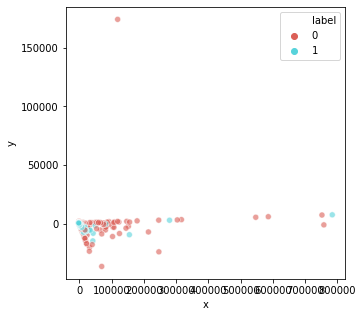

In [ ]:
#%%script false --no-raise-error
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

imputer = SimpleImputer()
data = imputer.fit_transform(feature_df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

temp_df = pd.DataFrame({'x': pca_result[:,0], 'y': pca_result[:,1], 'label': label_df['label']})

# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(temp_df.shape[0])

plt.figure(figsize=(5,5))
sns.scatterplot(
    x="x", y="y",
    hue="label",
    palette=sns.color_palette("hls", 2),
    data=temp_df,
    legend="full",
    alpha=0.6
)

# Outlier Handling

## Visualizing Boxplots

In [ ]:
%%script false --no-raise-error
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

columns = feature_df.columns
simple_imputer = SimpleImputer(strategy='median')
data = simple_imputer.fit_transform(feature_df)
data = pd.DataFrame(data=data, columns=columns)
fig, axs = plt.subplots(3,3)

axs[0,0].boxplot(data['additional_fare'], 0, 'gD')
axs[0,0].set_title('additional fare')

axs[0,1].boxplot(data['duration'], 0, 'gD')
axs[0,1].set_title('duration')

axs[0,2].boxplot(data['fare'], 0, 'gD')
axs[0,2].set_title('fare')

axs[1,0].boxplot(data['meter_waiting'], 0, 'gD')
axs[1,0].set_title('meter_waiting')

axs[1,1].boxplot(data['meter_waiting_fare'], 0, 'gD')
axs[1,1].set_title('meter_waiting_fare')

axs[1,2].boxplot(data['meter_waiting_till_pickup'], 0, 'gD')
axs[1,2].set_title('meter_waiting_till_pickup')

axs[2,0].boxplot(data['time_error'], 0, 'gD')
axs[2,0].set_title('time_error')

axs[2,1].boxplot(data['trip_distance'], 0, 'gD')
axs[2,1].set_title('trip_distance')

axs[2,2].boxplot(data['trip_time'], 0, 'gD')
axs[2,2].set_title('trip_time')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

plt.figure(figsize=(10,10))

plt.show()

## Z-Score

In [ ]:
from scipy import stats
from sklearn.impute import SimpleImputer

# columns = feature_df.columns
# simple_imputer = SimpleImputer(strategy='median')
# data = simple_imputer.fit_transform(feature_df)
# data = pd.DataFrame(data=data, columns=columns)

# z = np.abs(stats.zscore(data.drop(columns=['ismissing', 'fare'])))
# #z = np.abs(stats.zscore(data))
# print(z)

# outliers = np.where(z > 10)[0]
# print("\nNumber of outliers = {}\n".format(len(set(outliers))))

# print(outliers)

In [ ]:
# data.shape

In [ ]:
# data = data.drop(outliers)
# data.shape

In [ ]:
# qwe = np.where(label_df.loc[label_df.index[outliers]]['label']==0)
# len(set(qwe[0]))

In [ ]:
feature_df.describe()

In [ ]:
low = feature_df.quantile(0.001)
high = feature_df.quantile(0.999)
df = feature_df[~((feature_df < low) |(feature_df > high)).any(axis=1)]
df.describe()

In [ ]:
df.shape

(17095, 8)

In [ ]:
# def remove_outliers(xdf, ydf):
#     columns = xdf.columns
#     index = xdf.index.values
#     simple_imputer = SimpleImputer(strategy='median')
#     data = simple_imputer.fit_transform(xdf)
#     xdf = pd.DataFrame(data=data, columns=columns, index=index)
#     xdf.index.name = 'tripid'
#     z = np.abs(stats.zscore(xdf.drop(columns=['ismissing', 'fare'])))
#     #z = np.abs(stats.zscore(xdf))
#     outliers = np.where(z > 10)[0]
#     xdf = xdf.drop(xdf.index[outliers])
#     ydf = ydf.drop(ydf.index[outliers])

#     return (xdf, ydf)

def remove_outliers(feature_df, label_df, low, high):
    joined_df = feature_df.join(label_df)
    low = joined_df.drop(columns='label').quantile(low)
    high = joined_df.drop(columns='label').quantile(high)
    joined_df = joined_df[~((joined_df.drop(columns='label') < low) |(joined_df.drop(columns='label') > high)).any(axis=1)]
    index=joined_df.index.values
    y_df = pd.DataFrame(data=joined_df['label'], columns=['label'], index=index)
    feature_df = joined_df.drop(columns='label')

    return (feature_df, y_df)

print("Before: {}|{}".format(feature_df.shape, label_df.shape))
feature_df, label_df = remove_outliers(feature_df, label_df, 0.001, 0.999)
print("After: {}|{}".format(feature_df.shape, label_df.shape))

Before: (17176, 8)|(17176, 1)
After: (17103, 8)|(17103, 1)


In [ ]:
label_df['label'].value_counts()
# Here 82 incorrect labeled records has been deleted as outliers

1    15460
0     1643
Name: label, dtype: int64

In [ ]:
set_cross_features(feature_df)
feature_df.head()

In [ ]:
feature_df.describe()

## Feature Coorelation

Text(0, 0.5, 'Pearson Coeerelation')

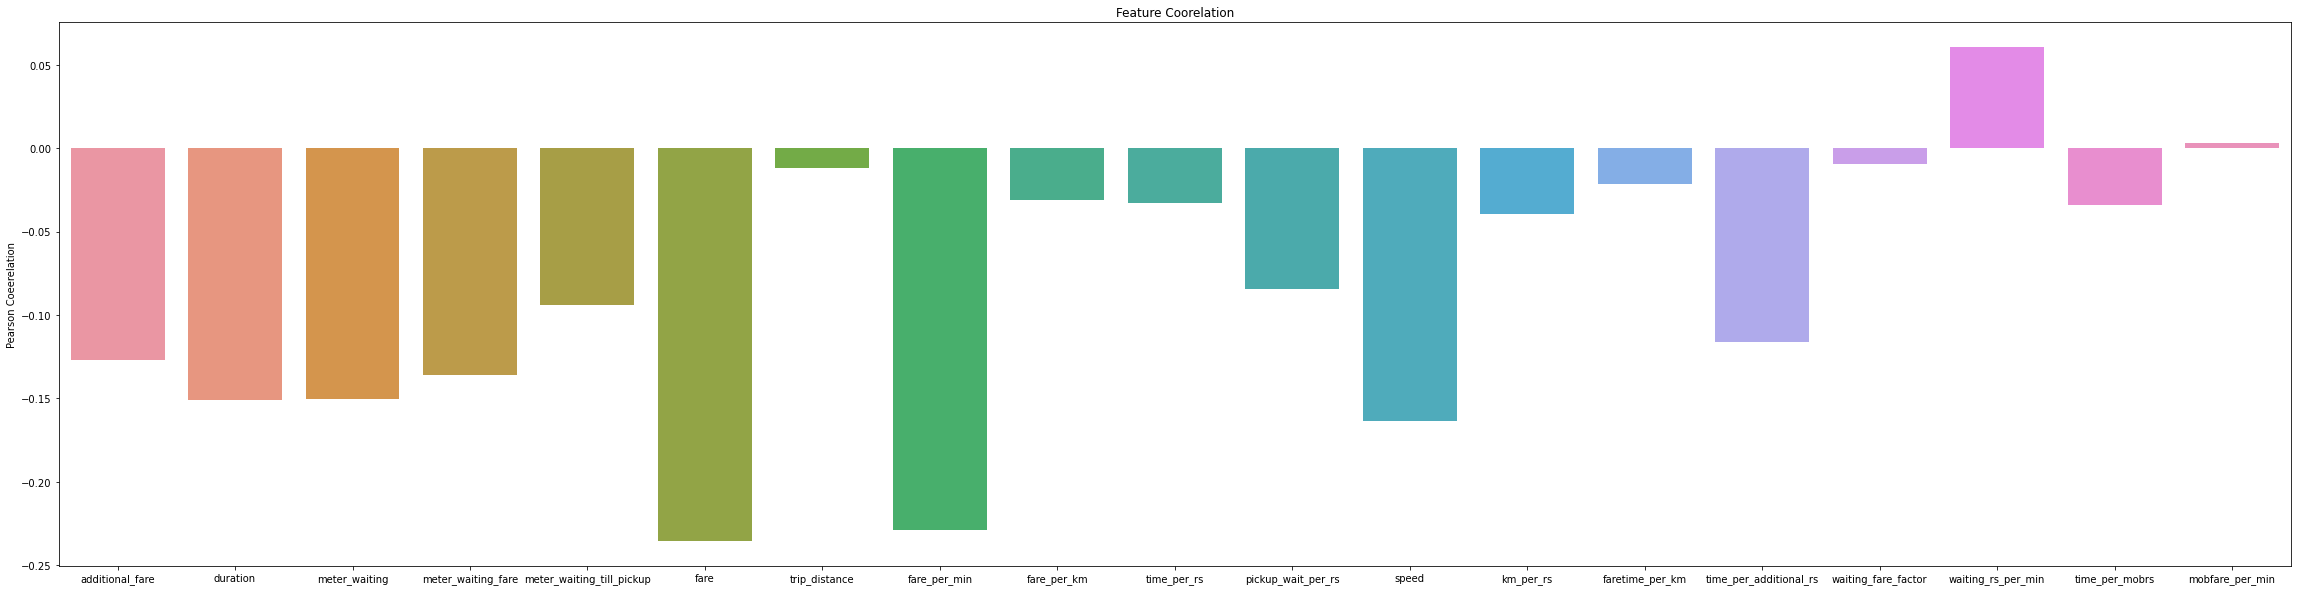

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

corr_df = feature_df.copy()
columns = corr_df.columns

cor = []
for col in columns:
    cor.append(corr_df[col].corr(label_df['label'], method="pearson"))

plt.figure(figsize=(40,10))
plt.title("Feature Coorelation")
sns.barplot(x=columns, y=cor)
plt.ylabel("Pearson Coeerelation")

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import f1_score

RANDOM_SEED = 6    # Set a random seed for reproducibility!

# Building Models

## Setting-up the Pre-Processor

In [ ]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)

# SimpleImputer(strategy='median', add_indicator=False) - RandomForest model
# SimpleImputer(strategy='median', add_indicator=True) - LogisticRegression
# SimpleImputer(strategy='most_frequent', add_indicator=True) -XGBClassifier
preprocessor = Pipeline([
    #('simple_imputer', SimpleImputer(strategy='median')), #, add_indicator=True
    ('scaler', MinMaxScaler())
])

## Selecting the best model

In [ ]:
%%script false --no-raise-error
models = [
    XGBClassifier(max_depth=7, learning_rate=0.01, n_estimators=500, eval_metric='rmse') #, objective='binary:hinge'
    RandomForestClassifier(class_weight={1: 0.8, 0: 0.2}, criterion='entropy', max_depth=15, max_features=5, min_impurity_decrease=0, n_estimators=300, random_state=6),
    LogisticRegression(C=100, class_weight={1: 0.2, 0: 0.8}, max_iter=100, penalty='l1', solver='liblinear', random_state=0, n_jobs=-1)
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(random_state=0),
    SGDClassifier(),
    LinearSVC()
]

processed_models = {}
for model in models:
    name = model.__class__.__name__
    processed_models[name] = Pipeline([("preprocessor", preprocessor),
                                      ("estimator", model)])
    
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for (name, model) in processed_models.items():
  f1_scores = cross_val_score(model, feature_df, label_df.label, scoring='f1_macro', cv=CV)
  for fold_idx, f1 in enumerate(f1_scores):
    entries.append((name, fold_idx, f1))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1_score'])

print(cv_df)
print(cv_df.groupby('model_name').f1_score.mean())

# Hyper-Parameter Tuning

## Grid Search

In [ ]:
%%script false --no-raise-error
# RandomForestClassifier(class_weight={1: 0.8, 0: 0.2}, criterion='entropy', max_depth=15, max_features=5, min_impurity_decrease=0, n_estimators=300, random_state=6, n_jobs=-1)
# LogisticRegression(C=100, class_weight={1: 0.2, 0: 0.8}, max_iter=100, penalty='l1', solver='liblinear', random_state=0, n_jobs=-1)
cross_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", XGBClassifier(booster='dart', objective='binary:logitraw', n_estimators=1000, max_depth=8, learning_rate=0.03, eval_metric='mae')),
])

# estimator parameter tuning - Random Forest
criterion = ['gini', 'entropy']
n_estimators = [100, 200, 300, 50]
max_depth = [3, 5, 10, 15]
max_features = [5, 'log2', 'auto']
min_impurity_decrease = [0, 0.2, 0.5, 1.0]
class_weight = [{1:0.5, 0:0.5}, {1:0.2, 0:0.8}, {1:0.8, 0:0.2}, {1:0.3, 0:0.7}]

param_grid1 = dict(estimators__criterion =criterion,
                  estimators__n_estimators =n_estimators,
                  estimators__max_depth=max_depth,
                  estimators__max_features =max_features,
                  estimators__min_impurity_decrease=min_impurity_decrease,
                  estimators__class_weight=class_weight)

# estimator parameter tuning - Linear Regression
penalty = ['l1', 'l2'] # , 'elasticnet'
C = [0.001, 0.01, 0.1, 1, 10, 100]
class_weight = [{1:0.5, 0:0.5}, {1:0.2, 0:0.8}, {1:0.8, 0:0.2}, {1:0.3, 0:0.7}]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [100, 200, 300]

param_grid2 = dict(estimators__penalty = penalty,
                  estimators__C = C,
                  estimators__max_iter = max_iter,
                  estimators__solver = solver,
                  estimators__class_weight=class_weight)

# estimator parameter tuning - XGBoost
booster = ['gbtree', 'dart']
max_depth = [5, 8, 10]
learning_rate = [0.01, 0.05, 0.1, 0.4]
n_estimators = [500, 800, 1000]
eval_metric = ['rmse', 'mae', 'logloss']
objective = ['reg:logistic', 'binary:logistic', 'binary:logitraw', 'binary:hinge']

param_grid3 = dict(estimators__booster = booster,
                   estimators__max_depth = max_depth,
                   estimators__learning_rate = learning_rate,
                   estimators__n_estimators = n_estimators,
                   estimators__eval_metric = eval_metric,
                   estimators__objective = objective)

# preprocessor parameter tuning
strategy = ['mean', 'median', 'most_frequent']
indicator = [True, False]
param_grid4 = dict(preprocessor__simple_imputer__strategy = strategy,
                   preprocessor__simple_imputer__add_indicator = indicator)

X_trainc, X_evalc, y_trainc, y_evalc = train_test_split(
    feature_df,
    label_df,
    test_size=0.33,
    shuffle=True,
    stratify=label_df,
    random_state=RANDOM_SEED
)

grid = GridSearchCV(estimator=cross_pipeline,
                    param_grid=param_grid4,
                    scoring='f1_macro',
                    verbose=1,
                    n_jobs=-1)
grid.fit(X_trainc, y_trainc)

print("Model: Random Forest")
print("Best param: ",grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
#print(cross_pipeline.get_params().keys())

## Random Search

In [ ]:
%%script false --no-raise-error
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

cross_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", XGBClassifier(
                      silent=True, nthread=6, tree_method='hist', eval_metric='auc')),
])

# estimator parameter tuning - XGBoost
booster = ['gbtree', 'dart']
max_depth = [4, 5, 6, 8, 10, 12]
learning_rate = [0.01, 0.03, 0.05, 0.1, 0.2]
n_estimators = [500, 800, 1000]
eval_metric = ['rmse', 'mae', 'logloss']
objective = ['reg:logistic', 'binary:logistic', 'binary:logitraw', 'binary:hinge']

param_grid1 = dict(estimators__booster = booster,
                   estimators__max_depth = max_depth,
                   estimators__learning_rate = learning_rate,
                   estimators__n_estimators = n_estimators,
                   estimators__eval_metric = eval_metric,
                   estimators__objective = objective)

param_grid2={
  "estimators__learning_rate"    : [ 0.01, 0.02, 0.03, 0.04, 0.05, 0.1 ] ,
  "estimators__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15 ],
  "estimators__min_child_weight" : [ 1, 3, 5, 7 ],
  "estimators__subsample"        : [0.8, 0.9, 1.0],
  "estimators__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
  "estimators__colsample_bytree" : [ 0.7, 0.8, 0.9, 1 ]
 }

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)

random_grid = RandomizedSearchCV(estimator=cross_pipeline, 
                                 param_distributions = param_grid1, 
                                 n_iter=10, 
                                 scoring='f1_macro', 
                                 n_jobs=4, 
                                 cv=skf.split(feature_df,label_df), 
                                 verbose=3, 
                                 random_state=1001)

random_grid.fit(feature_df, label_df)
print("Best Params: ", random_grid.best_params_)
print("Best Estimator: ", random_grid.best_estimator_)
print("Best Score: ", random_grid.best_score_)

# Train & Evaluation

### Building XGBoostWithEarlyStop esitimators to use with pipelines

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier

class XGBoostWithEarlyStop(BaseEstimator):
    def __init__(self, early_stopping_rounds=100, test_size=0.33, 
                 eval_metric=['error','logloss'], **estimator_params):
        self.early_stopping_rounds = early_stopping_rounds
        self.test_size = test_size
        self.eval_metric=eval_metric        
        if self.estimator is not None:
            self.set_params(**estimator_params)

    def set_params(self, **params):
        return self.estimator.set_params(**params)

    def get_params(self, **params):
        return self.estimator.get_params()

    def fit(self, X, y):
        x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=6)
        self.estimator.fit(x_train, y_train, 
                           early_stopping_rounds=self.early_stopping_rounds, 
                           eval_metric=self.eval_metric, eval_set=[(x_train, y_train),(x_val, y_val)])
        return self

    def predict(self, X):
        return self.estimator.predict(X)

class XGBoostRegressorWithEarlyStop(XGBoostWithEarlyStop):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBRegressor()
        super(XGBoostRegressorWithEarlyStop, self).__init__(*args, **kwargs)

class XGBoostClassifierWithEarlyStop(XGBoostWithEarlyStop):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBClassifier()
        super(XGBoostClassifierWithEarlyStop, self).__init__(*args, **kwargs)

## Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

X = feature_df
y = label_df

model = XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=1000, eval_metric='auc', reg_lambda=1.7, nthread=4)
fit_params = {'verbose': 200}

CV = 3
cv_df = pd.DataFrame(index=range(CV))
entries = []
f1_scores = cross_val_score(model, X, y.label, scoring='f1_macro', cv=3, fit_params=fit_params)
for fold_idx, f1 in enumerate(f1_scores):
    entries.append((fold_idx, f1))
cv_df = pd.DataFrame(entries, columns=['fold_idx', 'f1_macro'])

print(cv_df)
print("Mean F1_macro score: ", cv_df.f1_macro.mean())

   fold_idx  f1_macro
0         0  0.844235
1         1  0.865786
2         2  0.842560
Mean F1_macro score:  0.8508601740033743


In [ ]:
#estimator = XGBoostClassifierWithEarlyStop(max_depth=10, learning_rate=0.01, n_estimators=1000, eval_metric='rmse', reg_lambda=1.7) #, eval_metric='rmse'
estimator = XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=1000, eval_metric='auc', reg_lambda=1.7)

In [ ]:
#estimator=RandomForestClassifier(class_weight={1: 0.8, 0: 0.2}, criterion='entropy', max_depth=15, max_features=5, min_impurity_decrease=0, n_estimators=300, random_state=6)
#estimator = LogisticRegression(C=100, class_weight={1: 0.2, 0: 0.8}, max_iter=100, penalty='l1', solver='liblinear', random_state=0, n_jobs=-1)
# XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=1000, eval_metric='rmse') #, objective='binary:hinge'
#subsample=0.8, min_child_weight=1, max_depth=8/4, learning_rate=0.05, gamma=0.2, colsample_bytree=1, n_estimators=1000, objective='binary:logistic', silent=True, nthread=6, tree_method='hist', eval_metric='auc'

# estimator = XGBClassifier(booster='dart', subsample=0.8, min_child_weight=7, max_depth=15, learning_rate=0.01, gamma=0.4, colsample_bytree=1,
#                           colsample_bynode=1, colsample_bylevel=1, base_score=0.5, n_estimators=1000, objective='binary:logistic',
#                       importance_type='gain', max_delta_step=0, missing=None, monotone_constrains=None, silent=True, 
#                       njobs=6, num_parallel_tree=1, nthread=6, random_state=0, eval_metric='auc', reg_alpha=0, reg_lambda=1, scale_pos_weight=1, tree_method='hist', 
#                       validate_parameters=False)

# estimator = XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=1000, eval_metric='rmse')

# estimator = XGBClassifier(booster='dart', subsample=0.8, min_child_weight=1, max_depth=12, learning_rate=0.05, gamma=0.2, colsample_bytree=1,
#                           colsample_bynode=1, colsample_bylevel=1, base_score=0.5, n_estimators=1000, objective='binary:logitraw',
#                       importance_type='gain', max_delta_step=0, missing=None, monotone_constrains=None, silent=True, 
#                       njobs=6, num_parallel_tree=1, nthread=6, random_state=0, eval_metric='rmse', reg_alpha=0, reg_lambda=1, scale_pos_weight=1, tree_method='hist', 
#                       validate_parameters=False)
full_pipeline = Pipeline([
    #("preprocessor", preprocessor),
    ("estimators", estimator),
])

In [ ]:
feature_df.shape

(17103, 18)

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(
    feature_df,
    label_df,
    test_size=0.33,
    shuffle=True,
    stratify=label_df,
    random_state=RANDOM_SEED
)

In [ ]:
%%time

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
preds = full_pipeline.predict(X_eval)
print(preds)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1 1 1 ... 1 1 1]
CPU times: user 1min 9s, sys: 65.6 ms, total: 1min 9s
Wall time: 1min 9s


### Plot error for checking for overfitting

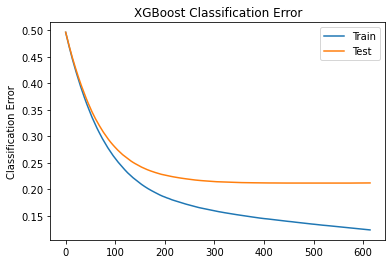

In [ ]:

# retrieve performance metrics
results = full_pipeline[-1].estimator.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

## Identify Feature Importances

[0.03947121 0.03072667 0.02934278 0.02996339 0.02769251 0.11429037
 0.02882728 0.03273835 0.04132978 0.27658364 0.02512566 0.04285924
 0.07962227 0.04112973 0.02678323 0.03288443 0.03058815 0.05239107
 0.01765026]
{'additional_fare': 0.03947121, 'duration': 0.030726671, 'meter_waiting': 0.02934278, 'meter_waiting_fare': 0.029963389, 'meter_waiting_till_pickup': 0.027692512, 'fare': 0.11429037, 'trip_distance': 0.028827282, 'fare_per_min': 0.03273835, 'fare_per_km': 0.041329775, 'time_per_rs': 0.27658364, 'pickup_wait_per_rs': 0.025125658, 'speed': 0.04285924, 'km_per_rs': 0.07962227, 'faretime_per_km': 0.041129727, 'time_per_additional_rs': 0.026783234, 'waiting_fare_factor': 0.03288443, 'waiting_rs_per_min': 0.030588152, 'time_per_mobrs': 0.052391067, 'mobfare_per_min': 0.017650263}


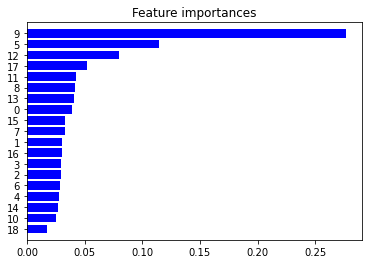

In [ ]:
print(full_pipeline[-1].feature_importances_)
importances = full_pipeline[-1].feature_importances_
feature_cols = X_train.columns

importance_dict = {}
for i in range(len(feature_cols)):
    importance_dict[feature_cols[i]] = importances[i]

print(importance_dict)

import matplotlib.pyplot as plt
indices = np.argsort(importances)
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="b", align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X_train.shape[1]), indices)
plt.ylim([-1, X_train.shape[1]])
plt.show()

In [ ]:
estimator = XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=1000, eval_metric='auc', reg_lambda=1.7)#, tree_method='hist')

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimator),
])

X_train, X_eval, y_train, y_eval = train_test_split(
    feature_df,
    label_df,
    test_size=0.33,
    shuffle=True,
    stratify=label_df,
    random_state=RANDOM_SEED
)

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
preds = full_pipeline.predict(X_eval)

# Predict probability on evaluation set
#y_proba = full_pipeline.predict_proba(X_eval)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
def calibrate_imbalance(pred_proba, threshold):
    '''
        pred_proba (2D array): predicted probabilities for each sample for all classes
        threshold (float): threshold probability to be taken for classification
    '''
    pos_proba = [i[1] for i in pred_proba]
    labels = []
    for prob in pos_proba:
        if prob > threshold: 
            labels.append(1)
        else:
            labels.append(0)

    return labels

#preds = calibrate_imbalance(y_proba, 0.6)

## Old Evaluation Results

In [ ]:
%%script false --no-raise-error
# Submission 3
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9728376035445965
Macro F1_Score: 0.8389292620233442


In [ ]:
%%script false --no-raise-error
# Submission 4 - XGB with half of the parameter tuning - booster='dart', objective='binary:logitraw', n_estimators=1000, max_depth=8, learning_rate=0.03, eval_metric='mae'
# Imputer - most_frequent
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9719752609199845
Macro F1_Score: 0.8395229839953459


In [ ]:
%%script false --no-raise-error
# Submission 4 - XGB with half of the parameter tuning - booster='dart', objective='binary:logitraw', n_estimators=1000, max_depth=8, learning_rate=0.03, eval_metric='mae'
# Imputer - median
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9720745965793796
Macro F1_Score: 0.8399301193210346


In [ ]:
%%script false --no-raise-error
# Submission 5/6 - XGB with half of the parameter tuning - booster='dart', objective='binary:logitraw', n_estimators=1000, max_depth=10, learning_rate=0.03, eval_metric='mae'
# Imputer - median 
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9724717473196176
Macro F1_Score: 0.8415658228983875


In [ ]:
%%script false --no-raise-error
# Submission xxx - XGB with half of the parameter tuning
# Imputer - median 
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9713020030816641
Macro F1_Score: 0.8294665151676665


In [ ]:
%%script false --no-raise-error
# Submission 7 - XGB with half of the parameter tuning - booster='dart', objective='binary:logitraw', n_estimators=1000, max_depth=10, learning_rate=0.03, eval_metric='mae'
# Outliers handled
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9734496124031007
Macro F1_Score: 0.8409801253504865


In [ ]:
%%script false --no-raise-error
# Submission 8 - max_depth=10, learning_rate=0.01, n_estimators=1000, eval_metric='rmse' with outlier handling
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9736359246740706
Macro F1_Score: 0.8359892330552674


In [ ]:
%%script false --no-raise-error
# Submission 9 - objective = 'binary:hinge', max_depth=10, learning_rate=0.01, n_estimators=1000, eval_metric='rmse' with outlier handling
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

# leaderboard loss from submission 8

F1_Score: 0.9729886726691839
Macro F1_Score: 0.8366554534130022


In [ ]:
%%script false --no-raise-error
# Submission 10 - submission 8 without time-error
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9732393005506715
Macro F1_Score: 0.8349219503848648


In [ ]:
%%script false --no-raise-error
# Submission 11 - Submission 8 with ismissing column
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

#3nd best model

F1_Score: 0.9733539293299864
Macro F1_Score: 0.8336836165496939


In [ ]:
%%script false --no-raise-error
# XGBClassifier(booster='dart', subsample=0.8, min_child_weight=1, max_depth=12, learning_rate=0.05, gamma=0.2, colsample_bytree=1,
#                           colsample_bynode=1, colsample_bylevel=1, base_score=0.5, n_estimators=1000, objective='binary:logitraw',
#                       importance_type='gain', max_delta_step=0, missing=None, monotone_constrains=None, silent=True, 
#                       njobs=6, num_parallel_tree=1, nthread=6, random_state=0, eval_metric='rmse', reg_alpha=0, reg_lambda=1, scale_pos_weight=1, tree_method='hist', 
#                       validate_parameters=False)

# Did not submit as with low score
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9721146398140975
Macro F1_Score: 0.8315508821388085


In [ ]:
%%script false --no-raise-error
# Submission 13 - submission 11 with learning_rate=0.05, eval_metric='logloss'
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9731245166279968
Macro F1_Score: 0.8348155334231686


In [ ]:
%%script false --no-raise-error
# Submission 14 - Submission 13 with reg_lambda=1.5
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

#score 0.97703

F1_Score: 0.9730304494925085
Macro F1_Score: 0.8340562083528116


In [ ]:
%%script false --no-raise-error
# Submission 15 - Submission 11 with reg_lambda=1.7
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

#score 0.97736

F1_Score: 0.9737451737451738
Macro F1_Score: 0.8357614757614757


In [ ]:
# Submission 16 - booster='dart', n_jobs=6, objective='binary:logitraw', n_estimators=1000, max_depth=10, learning_rate=0.03, eval_metric='mae', reg_lambda=2
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9722384003106194
Macro F1_Score: 0.8368498890905915


In [ ]:
# didn't submit - submission 11 with subsample=0.8, reg_lambda=1.5
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9742402315484805
Macro F1_Score: 0.8379581046010558


In [ ]:
# did not submit
print("F1_Score: {}".format(f1_score(y_eval, preds))) # above without ismissing
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9739583333333333
Macro F1_Score: 0.835633875186846


In [ ]:
# Submission 17 - submission 11 with subsample=0.8, reg_lambda=1.5, max_delta_step=2
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9745321242523636
Macro F1_Score: 0.8396150554147723


In [ ]:
# Submission 18 - max_depth=10, learning_rate=0.01, n_estimators=900, eval_metric='rmse', reg_lambda=1.7, subsample=0.8, max_delta_step=2, gamma=0.2 without 'ismissing'
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9739583333333333
Macro F1_Score: 0.835633875186846


In [ ]:
# Submission 19 - Submission 15 with probability thresholding = 0.7
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9714229981468838
Macro F1_Score: 0.8402298704736405


In [ ]:
# Submission 23 - Submission 15 with fare_per_min, fare_per_km features (0 time & duration points removed)
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

#lowest score (test data above 0s repaced with median)

F1_Score: 0.9798613403763619
Macro F1_Score: 0.8531593697397504


In [ ]:
# Submission 24 - Submission 15 with fare_per_min, fare_per_km features (0 time & duration points replaced with 0.01)
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

#score - 0.97809 XGB best model

F1_Score: 0.9789327344669019
Macro F1_Score: 0.8717841689060913


In [ ]:
# sub 24 couldn't be re generated
# Submission 28 - fare_per_min, fare_per_km features (for 0 time & duration points fare_per_min, fare_per_km set to -1
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9766223688039577
Macro F1_Score: 0.8521529923115834


In [ ]:
# Submission 29 - Submission 28 with time_per_rs feature, Z = 10
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

# Score - 0.97806

F1_Score: 0.9766138384228837
Macro F1_Score: 0.8567851800810071


In [ ]:
# Submission 34 - sub 29 without outlier/missing/normalization
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

# Best XGB Score - 0.97853

F1_Score: 0.9749830966869508
Macro F1_Score: 0.8560194671252013


In [ ]:
# Submission 35 - sub 34 with percentile outlier handling (low=0.001, high=0.999)
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))
print("Mean F1_macro score: ", cv_df.f1_macro.mean())
# Best XGB Score - 0.97898

F1_Score: 0.9756381636416578
Macro F1_Score: 0.8544503251789586
Mean F1_macro score:  0.8417539833145966


In [ ]:
# sub 35 with 'pickup_wait_per_rs', 'additional_fare_factor', removing 'time_error'
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.9771200467335215
Macro F1_Score: 0.8670501991682085


In [ ]:
# Submission 41 - sub 35 with 'pickup_wait_per_rs', 'additional_fare_factor', 'speed' removing 'time_error'
# cross features set after outlier removing
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))
print("Mean F1_macro score: ", cv_df.f1_macro.mean())

# Best XGB Score - 0.97947

F1_Score: 0.9769880570929216
Macro F1_Score: 0.8686760305687055
Mean F1_macro score:  0.8503323096718981


## New Evaluation Results

In [ ]:
# sub 41 with 'dayofweek' feature
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))
print("Mean F1_macro score: ", cv_df.f1_macro.mean())

F1_Score: 0.977471353660905
Macro F1_Score: 0.8715639596587353
Mean F1_macro score:  0.8496441396175153


In [ ]:
# Submission 45 - sub 41 with 'dayofweek', 'km_per_rs', 'faretime_per_km' 
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))
print("Mean F1_macro score: ", cv_df.f1_macro.mean())

# best score - 0.97962

F1_Score: 0.9774625995725665
Macro F1_Score: 0.8720310985790398
Mean F1_macro score:  0.8485893604034994


In [ ]:
#Submission 46 - sub 45 with 'time_per_additional_rs', 'waiting_fare_factor'
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))
print("Mean F1_macro score: ", cv_df.f1_macro.mean())

# score - 0.97917

F1_Score: 0.9775619232637202
Macro F1_Score: 0.8724667622360898
Mean F1_macro score:  0.8491833408251038


In [ ]:
# Submission 48 - sub 46 with remove 'additional_fare_factor' & 'trip_time', add 'waiting_rs_per_min', 'time_per_mobrs'
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))
print("Mean F1_macro score: ", cv_df.f1_macro.mean())

#score - 0.97900

F1_Score: 0.9772727272727272
Macro F1_Score: 0.8706928152492668
Mean F1_macro score:  0.8508601740033743


In [ ]:
# above 48 with 'mobfare_per_min'
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))
print("Mean F1_macro score: ", cv_df.f1_macro.mean())

F1_Score: 0.9774844720496895
Macro F1_Score: 0.8708560571630561
Mean F1_macro score:  0.8486746834180442


Text(0.5, 15.0, 'Predicted')

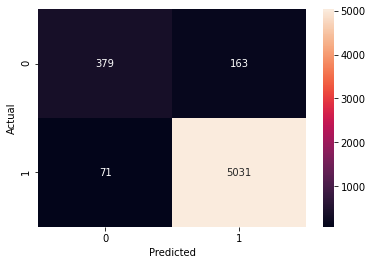

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_eval, preds)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Predicting on Test Data

In [ ]:
%%time 

full_pipeline.fit(feature_df, label_df)
None

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 1min 43s, sys: 71.5 ms, total: 1min 43s
Wall time: 1min 43s


In [ ]:
test_features_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TaxiFare/test.csv", 
                               index_col="tripid")

feature_process(test_features_df)
print(test_features_df.shape)
test_features_df.head()

In [ ]:
test_features_df.isna().sum()

additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
fare                         0
trip_distance                0
fare_per_min                 0
fare_per_km                  0
time_per_rs                  0
pickup_wait_per_rs           0
speed                        0
km_per_rs                    0
faretime_per_km              0
time_per_additional_rs       0
waiting_fare_factor          0
waiting_rs_per_min           0
time_per_mobrs               0
dtype: int64

In [ ]:
test_predictions = full_pipeline.predict(test_features_df)
# test_proba = full_pipeline.predict_proba(test_features_df)
# test_predictions = calibrate_imbalance(test_proba, 0.7)

In [ ]:
submission_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TaxiFare/sample_submission.csv", 
                            index_col="tripid")

In [ ]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["prediction"] = test_predictions

submission_df.head()

,prediction
tripid,
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1


In [ ]:
submission_df.to_csv('/content/gdrive/My Drive/Colab Notebooks/TaxiFare/my_submission.csv', index=True)

In [ ]:
!head /content/gdrive/My\ Drive/Colab\ Notebooks/TaxiFare/my_submission.csv

In [ ]:
%%script false --no-raise-error
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 